In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib as plt
import os
import time
import keras

from matplotlib import pyplot as plt
from keras import layers
from keras.optimizers.legacy import Adam
from PIL import Image
from bs4 import *

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Scrape images from the web

In [ ]:
from image_scraper import scrape_google_images

food_categories = [
    'pizza',
    'hamburger', 
    'sushi',
    'tacos',
    'spaghetti',
    'icecream',
    'salad',
    'chickenwings',
    'donuts',
    'sandwich',
    'steak',
    'lobster',
    'frenchfries',
    'cake',
    'dumplings',
    'curry',
    'salmon',
    'cookies',
    'ramen',
    'chocolate'
]

# Create main data directory
data_dir = 'data'
os.makedirs(data_dir, exist_ok=True)

# Number of images to scrape per category
num_images_per_category = 400

# Scrape images for each food category
for category in food_categories:
    print(f"\n--- Scraping images for: {category} ---")
    
    # Create subdirectory for this food category
    category_dir = os.path.join(data_dir, category)
    
    # Check if directory already has enough images
    # if os.path.exists(category_dir) and len(os.listdir(category_dir)) >= 200:
    #     print(f"Directory {category} already has sufficient images, skipping...")
    #     continue
    
    # Create search query (add 'food' to make results more relevant)
    search_queries = [
        f"{category} food",
        f"{category} delicious",
        f"{category} recipe"
    ]

    for search_query in search_queries:
        try:
            # Scrape images for this category
            scrape_google_images(search_query, num_images_per_category, category_dir)
            print(f"Completed scraping for {search_query}")
            
            # Add a delay between categories to be respectful to Google's servers
            time.sleep(1)
            
        except Exception as e:
            print(f"Error scraping {category}: {str(e)}")
            continue

print("\n--- Image scraping completed for all categories ---")

# Display summary of scraped images
print("\nSummary of scraped images:")
for category in food_categories:
    category_path = os.path.join(data_dir, category)
    if os.path.exists(category_path):
        image_count = len([f for f in os.listdir(category_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
        print(f"{category}: {image_count} images")
    else:
        print(f"{category}: Directory not found")


--- Scraping images for: pizza ---
Downloaded pizza_food_0.jpg (base64)
Downloaded pizza_food_1.jpg (base64)
Downloaded pizza_food_2.jpg (base64)
Downloaded pizza_food_3.jpg (base64)
Downloaded pizza_food_4.jpg (base64)
Downloaded pizza_food_5.jpg
Downloaded pizza_food_6.jpg
Downloaded pizza_food_7.jpg
Downloaded pizza_food_8.jpg
Failed to download pizza_food_9.jpg. Status: 200
Downloaded pizza_food_9.jpg (base64)
Downloaded pizza_food_10.jpg (base64)
Downloaded pizza_food_11.jpg (base64)
Downloaded pizza_food_12.jpg (base64)
Downloaded pizza_food_13.jpg (base64)
Downloaded pizza_food_14.jpg (base64)
Downloaded pizza_food_15.jpg (base64)
Downloaded pizza_food_16.jpg (base64)
Downloaded pizza_food_17.jpg (base64)
Downloaded pizza_food_18.jpg (base64)
Downloaded pizza_food_19.jpg (base64)
Downloaded pizza_food_20.jpg (base64)
Downloaded pizza_food_21.jpg (base64)
Downloaded pizza_food_22.jpg (base64)
Downloaded pizza_food_23.jpg (base64)
Downloaded pizza_food_24.jpg (base64)
Downloaded 

KeyboardInterrupt: 

# Load Data

In [ ]:
data = keras.utils.image_dataset_from_directory('data', batch_size=32)

Found 1774 files belonging to 10 classes.


Split images into batches for training. I will use a batch size of 32.

In [4]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
batch[0].shape

(64, 256, 256, 3)

Let's take a quick look at some sample images from the dataset.

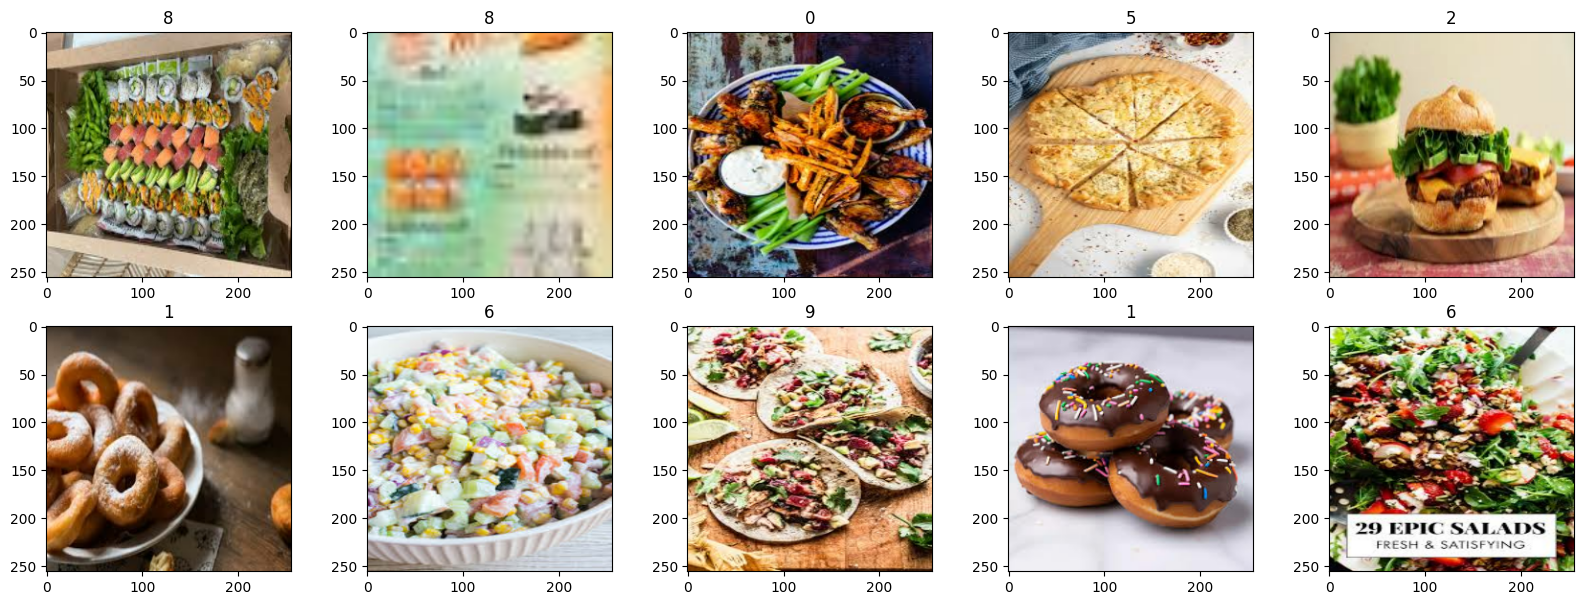

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))

for idx, img in enumerate(batch[0][:10]):
    ax[idx//5, idx%5].imshow(img.astype(int))
    ax[idx//5, idx%5].title.set_text(batch[1][idx])

Due to the nature of scraping images from the web, some of the images are not good representations of their respective category. Hopefully, having a large enough training data size will mitigate the effects of these bad images. If they continue to be an issue, I can manually inspect each image and delete the bad ones.

# Preprocessing

In [6]:
# scale images, set rgb values to between 0 and 1
data_scaled = data.map(lambda x, y : (x/255, y))

data_scaled.as_numpy_iterator().next()

(array([[[[0.9372549 , 0.85882354, 0.8235294 ],
          [0.9372549 , 0.85882354, 0.8235294 ],
          [0.9372549 , 0.85882354, 0.8235294 ],
          ...,
          [0.94291514, 0.84095436, 0.8762485 ],
          [0.94509804, 0.84313726, 0.8784314 ],
          [0.94509804, 0.84313726, 0.8784314 ]],
 
         [[0.9372549 , 0.85882354, 0.8235294 ],
          [0.9372549 , 0.85882354, 0.8235294 ],
          [0.9372549 , 0.85882354, 0.8235294 ],
          ...,
          [0.94291514, 0.84095436, 0.8762485 ],
          [0.94509804, 0.84313726, 0.8784314 ],
          [0.94509804, 0.84313726, 0.8784314 ]],
 
         [[0.9372549 , 0.85882354, 0.8235294 ],
          [0.9372549 , 0.85882354, 0.8235294 ],
          [0.9372549 , 0.85882354, 0.8235294 ],
          ...,
          [0.94291514, 0.84095436, 0.8762485 ],
          [0.94509804, 0.84313726, 0.8784314 ],
          [0.94509804, 0.84313726, 0.8784314 ]],
 
         ...,
 
         [[0.92941177, 0.80784315, 0.7372549 ],
          [0.92897

We will split the batches into training, validation, and testing partitions. THe split I will be using is 80% training, 10% validation, and 10% testing.

In [7]:
# count the number of batches
num_batches = len(data_scaled)

# Create training, validation, testing sets
train_size = int(num_batches * 0.8)
test_size = int(num_batches * 0.1)
val_size = num_batches - train_size - test_size

print(f'Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}')

train = data_scaled.take(train_size)
test = data_scaled.skip(train_size).take(test_size)
val = data_scaled.skip(train_size + test_size).take(val_size)

Train size: 22, Validation size: 4, Test size: 2


# Baseline CNN Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip, RandomRotation

num_classes = max(batch[1]) + 1

model = Sequential([
    # convolutional layer
    Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)),
    MaxPooling2D(),
    # convolutional layer
    Conv2D(64, (3,3), 1, activation='relu'),
    MaxPooling2D(),
    # convolutional layer
    Conv2D(128, (3,3), 1, activation='relu'),
    MaxPooling2D(),
    #
    Flatten(),
    #
    Dense(128, activation='relu'),
    # classification layer
    Dense(num_classes, activation='softmax')
])

# optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,011,402 (42.01 MB)

 Trainable params: 11,011,402 (42.01 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
logdir = 'logs'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = model.fit(
    train,
    epochs=30,
    validation_data=val,
    verbose=1
)

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.1165 - loss: 2.2736 - val_accuracy: 0.1807 - val_loss: 2.1185
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.1939 - loss: 2.0988 - val_accuracy: 0.1975 - val_loss: 2.0494
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.2997 - loss: 1.9657 - val_accuracy: 0.3824 - val_loss: 1.7641
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.3601 - loss: 1.7745 - val_accuracy: 0.4160 - val_loss: 1.6787
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.3963 - loss: 1.6464 - val_accuracy: 0.3655 - val_loss: 1.7404
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4453 - loss: 1.5471 - val_accuracy: 0.4622 - val_loss: 1.4948
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.4602 - loss: 1.5293 - val_accuracy: 0.4748 - val_loss: 1.4861
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.4943 - loss: 1.4517 - val_accuracy: 0.5126 - val_loss:

Let's visualize how the loss and accuracy improved over the training period.

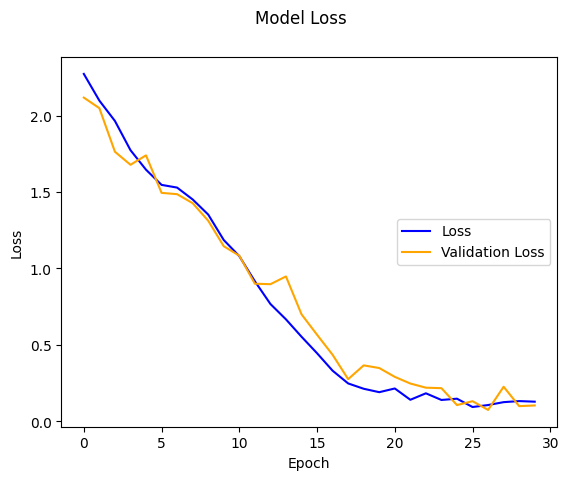

In [21]:
# visualize loss
fig = plt.figure()
plt.plot(history.history['loss'], color='blue', label='Loss')
plt.plot(history.history['val_loss'], color='orange', label='Validation Loss')
plt.legend(loc='center right')
plt.suptitle('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

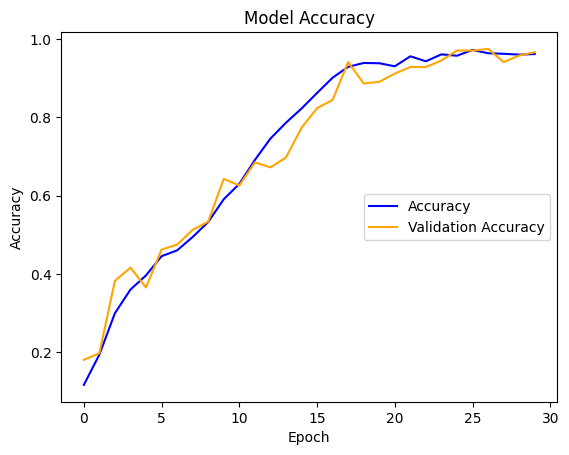

In [22]:
# visualize loss
fig = plt.figure()
plt.plot(history.history['accuracy'], color='blue', label='Accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.legend(loc='center right')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Using the accuracy metric, lets see how the model performs on new, unseen data.

In [23]:
from keras.metrics import CategoricalAccuracy

accuracy = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    y = tf.one_hot(y, num_classes)
    y_pred = model.predict(X)
    accuracy.update_state(y, y_pred)
    
print(f'Accuracy: {accuracy.result().numpy()}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
Accuracy: 0.96875


In [24]:
from keras.models import load_model

# we can save and load models for future use without needing to retrain
model.save(os.path.join('models', 'baseline_model.keras'))
baseline_model = load_model(os.path.join('models', 'baseline_model.keras'))

# Data Augmentation

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip, RandomRotation

num_classes = max(batch[1]) + 1

model = keras.Sequential([
    # data augmentation layers
    layers.RandomFlip('horizontal', input_shape=(256,256,3)),
    # layers.RandomRotation(0.2),
    # convolutional layer
    layers.Conv2D(32, (3,3), 1, activation='relu'),
    layers.MaxPooling2D(),
    # convolutional layer
    layers.Conv2D(64, (3,3), 1, activation='relu'),
    layers.MaxPooling2D(),
    # convolutional layer
    layers.Conv2D(128, (3,3), 1, activation='relu'),
    layers.MaxPooling2D(),
    #
    layers.Conv2D(256, (3,3), 1, activation='relu'),
    layers.MaxPooling2D(),
    #
    layers.Conv2D(512, (3,3), 1, activation='relu'),
    layers.MaxPooling2D(),
    #
    layers.Flatten(),
    #
    layers.Dense(512, activation='relu'),
    # classification layer
    layers.Dense(num_classes, activation='softmax')
])

# optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

/Users/davidpan/Desktop/repos/interviews/.venv/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,011,402 (42.01 MB)

 Trainable params: 11,011,402 (42.01 MB)

 Non-trainable params: 0 (0.00 B)